# Exercises

In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path
import os
print(os.getcwd())

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF


import seaborn as sns
# sns.set_theme(context='notebook',style='white',font_scale=1.5)

c:\Users\ptrso\OneDrive\Desktop\MasteRU\Quarter3\NRA\Assignments\Calcium_Imaging


In [2]:
# set path to video of the full field of view
input_tif_file_path_FOV = 'data/calcium_video.tif'   
input_tif_file_path = 'data/caiman_video_trial_0.tif' 

In [3]:
original_video = cm.load(input_tif_file_path) # load video with ROI
FOV = cm.load(input_tif_file_path_FOV) # load video with complete field of view (FOV)

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dynamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are chosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to a neuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

Video shape: (500, 300, 400)
<class 'caiman.base.movies.movie'>


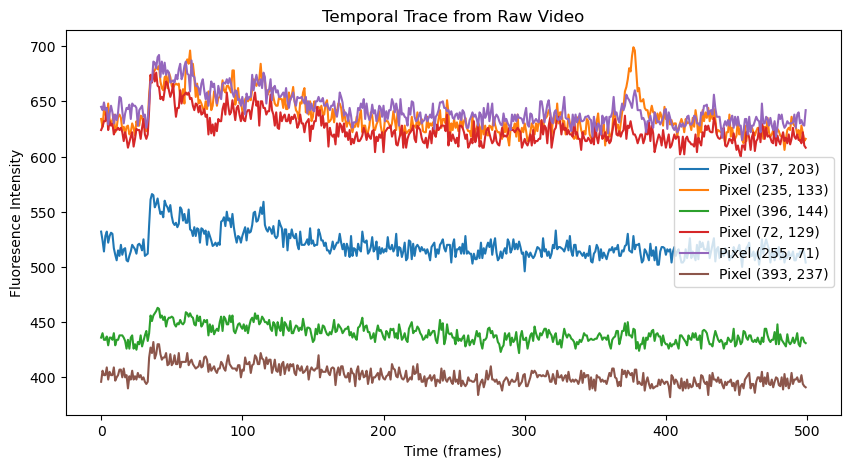

In [19]:
# To ensure reproducibility for B)
np.random.seed(1) # remove to observe different pixel-neuron traces
# print(original_video)

# Check video characteristics
print('Video shape:', original_video.shape)
print(type(original_video)) 

N = 6 # Number of pixels
n_frame, height, width = original_video.shape

x_crds = np.random.randint(0, width, size=N)  # x coordinates
y_crds = np.random.randint(0, height, size=N)  # y coordinates
traces = []
for y, x in zip(y_crds, x_crds):
    pixel_values = original_video[:, y, x]
    traces.append(pixel_values)

plt.figure(figsize=(10, 5))

for i, trace in enumerate(traces):
    plt.plot(traces[i], label=f'Pixel ({x_crds[i]}, {y_crds[i]})')

plt.xlabel('Time (frames)')
plt.ylabel('Fluoresence Intensity')
plt.legend()
plt.title('Temporal Trace from Raw Video')
plt.show()

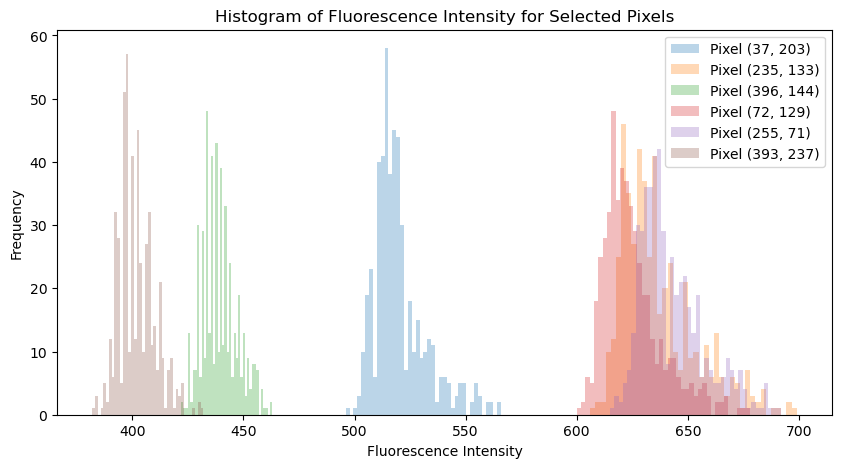

In [34]:
plt.figure(figsize=(10, 5))

for i, trace in enumerate(traces):
    plt.hist(trace, bins=40, alpha=0.3, label=f'Pixel ({x_crds[i]}, {y_crds[i]})')

plt.xlabel('Fluorescence Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Fluorescence Intensity for Selected Pixels')
plt.legend()
plt.show()

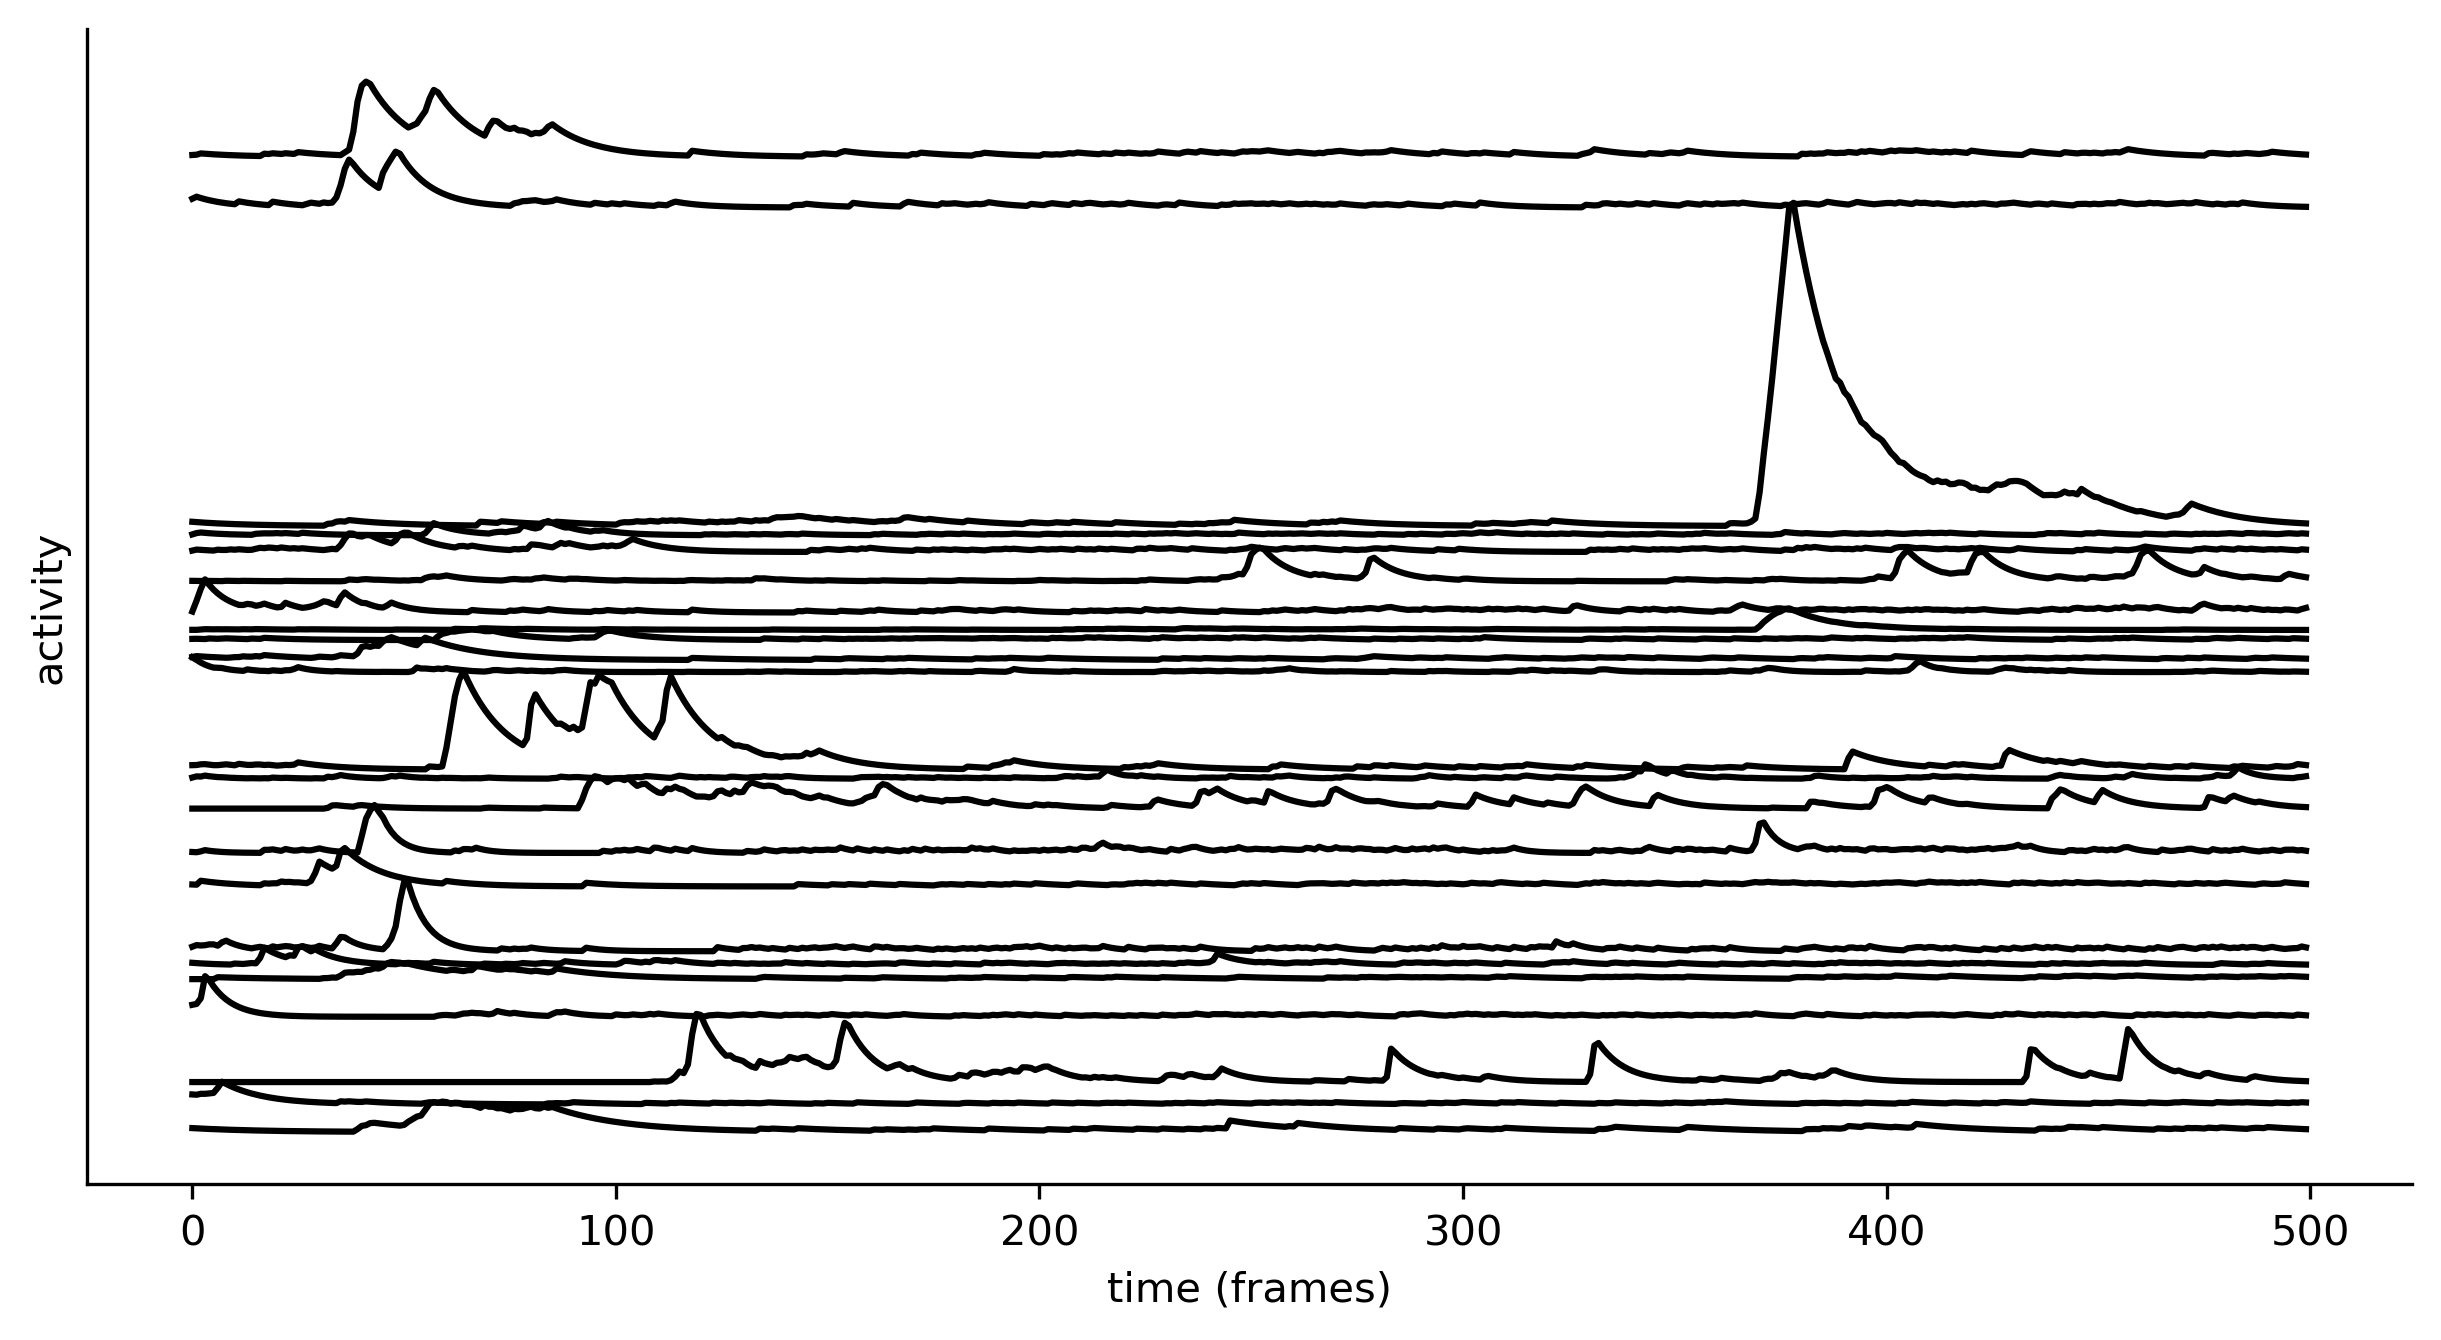

In [2]:
# MUST run source extraction and the rest of the code first
from IPython.display import Image
Image(filename="my_plot.png", width=800) # load image

### B1
Q1) The differences we observe between the regions is the fluorescence intensity (FLUINT) first of all. If the pixel are inside of a neuron they tend to have higher average fluorescence such as pixels (235, 133), (72, 129) and (393, 237) on the right of the graph.

Moreover, there are differences in the spread-variance of the histograms, some are broader than the others. For example the ones likely belonging to the background with lower FLUINT have narrow spread.

Pixel (37, 207) lies in the intermediate range and can belong to the neuropil which contrains subcellular structures like dendrites and axons which can still show a bit of fluorescence.

Q2) In order to judge if a pixel belongs to a neuron we can take measurements of the fluorescence intensity across the 500 frames from known neurons and then take their mean setting up a threshold. If the pixel's average FLUINT is above that then we can consider it being a neuron's pixel. For the current data a reasonable option would be around 600.

### B2
The activity traces extracted from the C matrix after motion correction and source extraction are noticeably clearer and more interpretable than the raw fluorescence traces from individual pixels. Raw traces often show gradual drifts, noisy oscillations, and overlapping signals from background or nearby structures. However, the C matrix traces isolates cleaner and more accurate transients while the it visibly reduces baseline fluctuations allowing for a more reliable identification of calcium events associated with neural firing. 

This improvement comes from the preprocessing pipeline. The motion correction aligns the video to a common frame reducing artifacts from brain movement, and CNMF decomposes the signal into spatially distinct sources, suppressing background and noise. Moreover, despite the error of source extraction it enables easier distinction between neighboring or overlapping sources compared to the unprocessed histogram traces or graph.

In [ ]:
# play video (a new window will open)
FOV.play(gain = 1,  #light intensity of video
         magnification = 1, #size of display movie
         fr = 20) # frame rate at which the movie is played

In [30]:
# Define parameters for motion correction in a dictionary

parameters_motion_correction = { 'pw_rigid': True,       # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                'gSig_filt': (5, 5),     # size of high pass spatial filtering, used in 1p data
                                'max_shifts': (25, 25),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                'niter_rig': 1 ,
                                'strides': (48, 48),     # create a new patch every x pixels for pw-rigid correction
                                'overlaps': (96, 96),    # overlap between pathes (size of patch strides+overlaps)
                                'upsample_factor_grid': 1,
                                'num_frames_split': 80,  # length in frames of each chunk of the movie (to be processed in parallel)
                                'max_deviation_rigid': 15, # maximum deviation allowed for patch with respect to rigid shifts
                                'shifts_opencv': True, 
                                'use_cuda': False, 
                                'nonneg_movie': True,
                                'border_nan': 'copy'}

parameters_motion_correction['min_mov'] = np.min(original_video) 

# pass parameters to caiman object
opts = params.CNMFParams(params_dict = parameters_motion_correction)

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


In [27]:
# Speeding up the motion correction by using parallel processing
n_processes = psutil.cpu_count() # counts local cpus
cm.cluster.stop_server() #stop any already running clusters

# Start a new cluster
c, dview, n_processes = cm.cluster.setup_cluster(backend='multiprocessing',
                                                 n_processes=n_processes,
                                                 single_thread=False)

In [32]:
# make directory to save motion corrected videos
Path("data/motion_corrected").mkdir(parents=True, exist_ok=True)

# create an object for motion correction
mc = MotionCorrect(input_tif_file_path, dview = dview, **opts.get_group('motion'))

# Perform rigid motion correction
mc.motion_correct_rigid(save_movie = True, template = None)

# perform non-rigid motion correction
total_template_rig = mc.total_template_rig
mc.motion_correct_pwrigid(save_movie=True, template = total_template_rig)
fname_tot_els = mc.fname_tot_els[0]

# reshape memmap files for source extraction
m_els = cm.load(fname_tot_els)
fname_tot_els  = m_els.save('motion_corrected_video.mmap',  order='C')

# Reshape to F ordering which facilates the source extraction
fname_tot_els_name = Path(fname_tot_els).parts[-1]

output_path = Path(f"data/motion_corrected/{fname_tot_els_name}")
if output_path.exists():
    output_path.unlink()  # Removes the existing file

Path(fname_tot_els).rename(output_path)

Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


WindowsPath('data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap')

In [24]:
# load motion corrected video
input_mmap_file_path = 'data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap'
Yr, dims, T = cm.load_memmap(input_mmap_file_path)         # load mmap file
images = Yr.T.reshape((T,) + dims, order='F' )

In [28]:
# create dictionary with source extraction parameters

parameters_source_extraction ={ 'fr': 10,               # movie frame rate
                               'decay_time': 0.1,       # length of a typical transient in seconds
                               'min_corr': 0.7,   # min peak value from correlation image
                               'min_pnr': 7,     # min peak to noise ration from PNR image
                                'p': 1,                # order of the autoregressive system 
                               'K': None,              # upper bound on number of components per patch, in general None
                               'gSig': (4, 4),         # gaussian width of a 2D gaussian kernel, which approximates a neuron
                               'gSiz': (17, 17),       # average diameter of a neuron, in general 4*gSig+1
                               'ring_size_factor': 1.4, # radius of ring is gSiz*ring_size_factor
                               'merge_thr': 0.7, 'rf': 60,
                               'stride': 30, 'tsub': 1, 'ssub': 2, 'p_tsub': 1, 'p_ssub': 2, 'low_rank_background': None,
                               'nb': 0, 'nb_patch': 0, 'ssub_B': 2, 'init_iter': 2,
                               'method_init': 'corr_pnr', 'method_deconvolution': 'oasis',
                               'update_background_components': True,
                               'center_psf': True, 'border_pix': 0, 'normalize_init': False,
                               'del_duplicates': True, 'only_init': True}
# create caiman parameters objects
opts = params.CNMFParams(params_dict=parameters_source_extraction)

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


In [29]:
cnmf_object = cnmf.CNMF(n_processes=n_processes, dview=dview, params=opts)
cnmf_object.fit(images)

c:\Users\ptrso\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],


In [30]:
# Save the cnmf object as a hdf5 file
Path("data/source_extracted").mkdir(parents=True, exist_ok=True)
output_cnmf_file_path = 'data/source_extracted/calcium_video_0_cnmf.hdf5'
cnmf_object.save(output_cnmf_file_path)

In [31]:
cnmf_object.estimates.C.shape
# type(cnmf_object.estimates.C)

(24, 500)

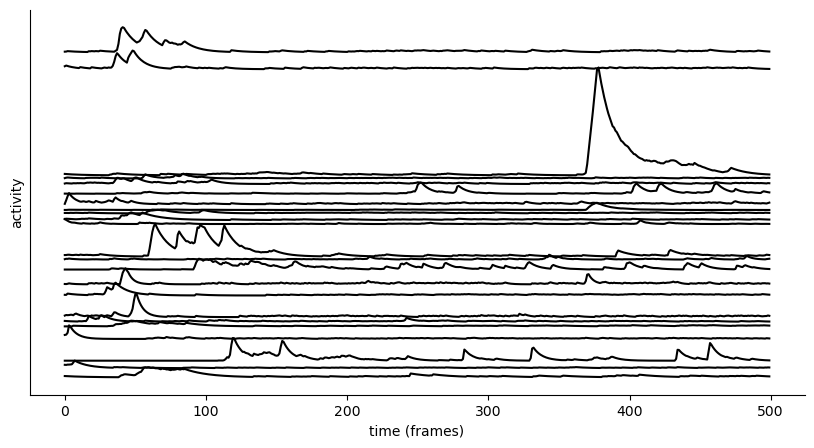

In [32]:
figure, axes = plt.subplots(1,figsize=(10,5))
C_0 = cnmf_object.estimates.C.copy()
C_0[1] += C_0[0].min()
for i in range(1, len(C_0)):
    C_0[i] += C_0[i].min() + C_0[:i].max()
    axes.plot(C_0[i],c='k')
axes.set_xlabel('time (frames)')
axes.set_yticks([])
sns.despine()
axes.set_ylabel('activity')
plt.savefig("my_plot.png", dpi=300, bbox_inches='tight')